In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import nltk
from nltk.corpus import stopwords
import re

In [2]:
# Load datasets
train_data = pd.read_csv('train_product_data.csv')
test_data = pd.read_csv('test_data.csv')
test_results = pd.read_csv('test_results.csv')

In [3]:
# Check for missing values and data types
print(train_data.info())
print(train_data.isnull().sum())
print(test_data.info())
print(test_data.isnull().sum())
print(test_results.info())
print(test_results.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  14999 non-null  object 
 1   crawl_timestamp          14999 non-null  object 
 2   product_url              14999 non-null  object 
 3   product_name             14999 non-null  object 
 4   product_category_tree    14999 non-null  object 
 5   pid                      14999 non-null  object 
 6   retail_price             14942 non-null  float64
 7   discounted_price         14942 non-null  float64
 8   image                    14996 non-null  object 
 9   is_FK_Advantage_product  14999 non-null  bool   
 10  description              14998 non-null  object 
 11  product_rating           14999 non-null  object 
 12  overall_rating           14999 non-null  object 
 13  brand                    10289 non-null  object 
 14  product_specifications

In [9]:
# Fill missing values in the 'description' column with a placeholder text
train_data['description'].fillna('missing', inplace=True)
test_data['description'].fillna('missing', inplace=True)

# Verify that there are no NaN values in the description columns
assert train_data['description'].isnull().sum() == 0
assert test_data['description'].isnull().sum() == 0


## Descriptive Analysis and Visualizations

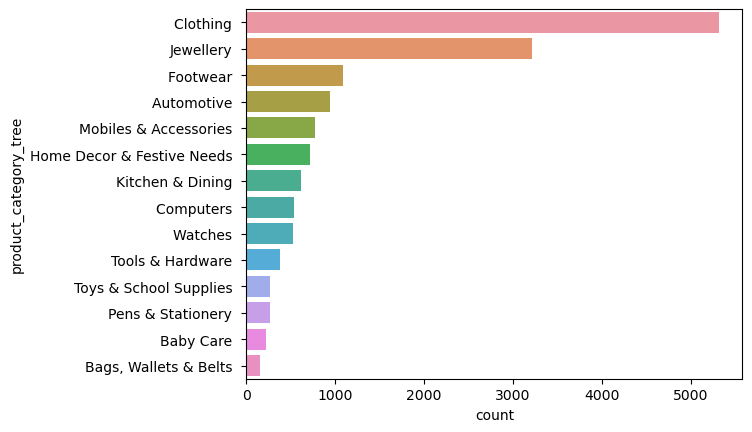

In [10]:
# Plot category distribution
sns.countplot(y='product_category_tree', data=train_data, order=train_data['product_category_tree'].value_counts().index)
plt.show()


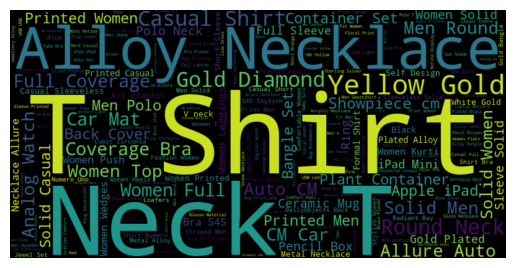

In [11]:
# Generate word cloud for product names
wordcloud = WordCloud(width=800, height=400).generate(' '.join(train_data['product_name']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Text Preprocessing and Feature Engineering

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenization and removal of stop words
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    # Join tokens back to string
    return ' '.join(tokens)

# Apply text preprocessing
train_data['processed_description'] = train_data['description'].apply(preprocess_text)
test_data['processed_description'] = test_data['description'].apply(preprocess_text)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_data['processed_description'])
X_test_tfidf = vectorizer.transform(test_data['processed_description'])
y_train = train_data['product_category_tree']

##  Model Development

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.15, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

# Evaluate the model on validation set
print(classification_report(y_val, y_val_pred))


                             precision    recall  f1-score   support

                Automotive        0.97      0.99      0.98       141
                 Baby Care        0.90      0.63      0.75        30
     Bags, Wallets & Belts        1.00      0.85      0.92        26
                  Clothing        0.97      1.00      0.98       808
                 Computers        0.97      0.97      0.97        74
                  Footwear        0.98      0.99      0.99       150
Home Decor & Festive Needs        0.95      0.98      0.97       116
                 Jewellery        0.99      1.00      1.00       483
          Kitchen & Dining        0.98      0.97      0.97        86
     Mobiles & Accessories        0.99      0.96      0.97       121
         Pens & Stationery        0.96      0.56      0.71        41
          Tools & Hardware        1.00      0.90      0.95        48
    Toys & School Supplies        0.71      0.83      0.77        36
                   Watches       

## Fine Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate the best model on validation set
y_val_pred_best = best_model.predict(X_val)
print(classification_report(y_val, y_val_pred_best))


                             precision    recall  f1-score   support

                Automotive        0.97      1.00      0.99       141
                 Baby Care        0.88      0.73      0.80        30
     Bags, Wallets & Belts        1.00      0.92      0.96        26
                  Clothing        0.99      1.00      0.99       808
                 Computers        0.96      1.00      0.98        74
                  Footwear        1.00      0.99      1.00       150
Home Decor & Festive Needs        0.97      0.99      0.98       116
                 Jewellery        1.00      1.00      1.00       483
          Kitchen & Dining        1.00      0.99      0.99        86
     Mobiles & Accessories        1.00      0.95      0.97       121
         Pens & Stationery        0.94      0.76      0.84        41
          Tools & Hardware        1.00      0.96      0.98        48
    Toys & School Supplies        0.76      0.86      0.81        36
                   Watches       

## Evaluate on Test Data

In [17]:
# Predict on the test data
y_test_pred = best_model.predict(X_test_tfidf)

# Load the actual test results
y_test_actual = test_results['product_category_tree']

# Evaluate the model on test set
print(classification_report(y_test_actual, y_test_pred))


                             precision    recall  f1-score   support

                Automotive        0.74      0.93      0.82        75
                 Baby Care        0.68      0.07      0.12       259
     Bags, Wallets & Belts        1.00      0.80      0.89       107
                  Clothing        0.91      0.99      0.95       882
                 Computers        0.94      0.96      0.95        47
                  Footwear        0.99      0.99      0.99       144
Home Decor & Festive Needs        0.47      0.84      0.60       215
                 Jewellery        0.96      0.96      0.96       313
          Kitchen & Dining        0.70      0.86      0.77        37
     Mobiles & Accessories        0.95      0.95      0.95       331
         Pens & Stationery        0.88      0.78      0.83        49
          Tools & Hardware        1.00      0.08      0.15        12
    Toys & School Supplies        0.98      0.78      0.87        59
                   Watches       